In [40]:
import numpy  as np
import healpy as hp
import matplotlib.pyplot as plt
import sys
sys.path.append('../sht')
from  mask_deconvolution import MaskDeconvolution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's load a test, apodized mask

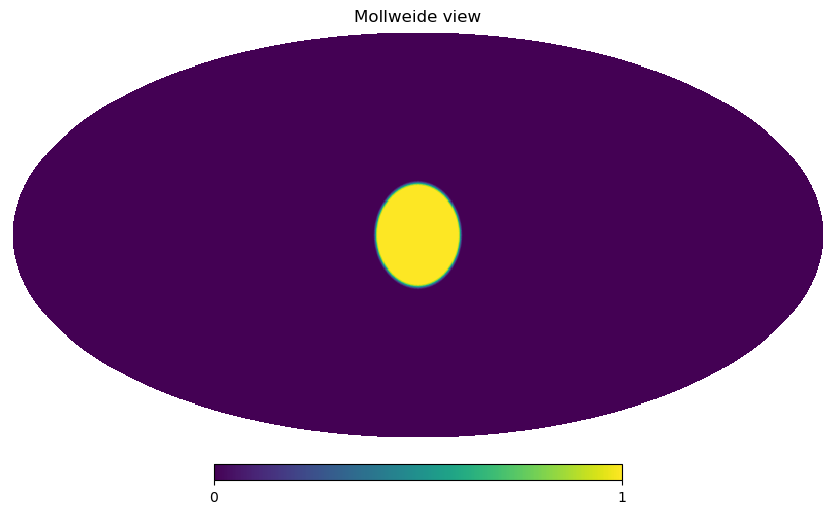

In [41]:
# This mask has a "C1" apodization on a scale of 2.5 degrees
# It has an nside of 1024
mask = np.loadtxt('../data/test_mask.txt')

hp.mollview(mask)

Let's make some mock data

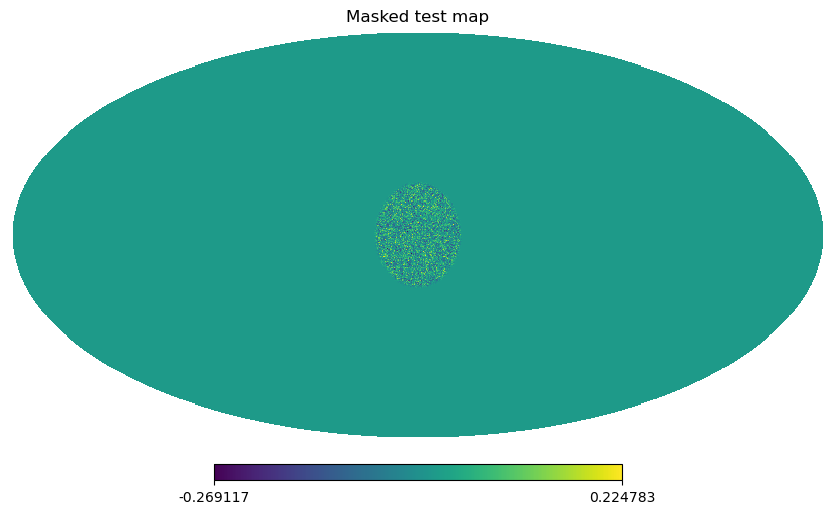

In [42]:
# Load a test CMB lensing angular power spectrum 
clkk = np.loadtxt('../data/clkk_lmax6000.txt')
ells = np.arange(len(clkk))

# Let's draw a realization of this field
nside = 1024
kmap = hp.synfast(clkk, nside=nside)
masked_kmap = mask*kmap
hp.mollview(masked_kmap, title="Masked test map")

In [43]:
Nl = 2**8
lmax = Nl - 1

In [44]:
cl = hp.anafast(masked_kmap, lmax=lmax)
wl = hp.anafast(mask)
# Let's ignore the noise for now
nl = np.zeros_like(cl)

We initialize an instance of the MaskDeconvolution class. This computes the coupling matrix. We won't have to run it again as long as we're dealing with the same mask.

In [45]:
MD = MaskDeconvolution(lmax, wl)

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...


We can then very quickly deconvolve the mode-coupling matrix from some observed bandpowers.

In [46]:
NperBin = 2**4
binned_ells, Cb_decoupled = MD(cl, nl, NperBin)
# Convolve the theory with the bandpower window functions
convolved_theory_cl = MD.convolve_theory_Cls(clkk[:(lmax+1)])

(0.0, 297.5)

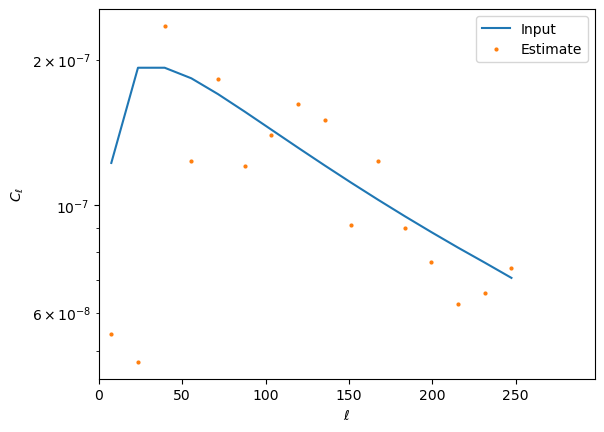

In [52]:
plt.plot(binned_ells, convolved_theory_cl, label='Input')
plt.plot(binned_ells, Cb_decoupled, label='Estimate', ls='', marker='o', markersize=2)
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.legend()
plt.xlim([0,binned_ells[-1]+50])

Let's average over many realizations

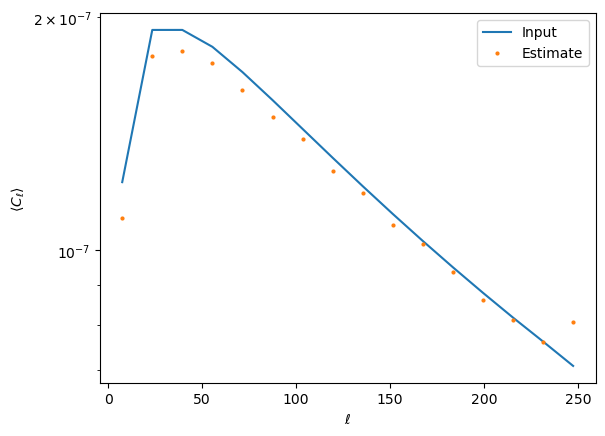

In [53]:
N = 300

avg_Cb_decoupled = np.zeros_like(Cb_decoupled)

for i in range(N):
    kmap = hp.synfast(clkk, nside=nside)
    masked_kmap = mask*kmap
    cl = hp.anafast(masked_kmap, lmax=lmax)
    binned_ells, Cb_decoupled = MD(cl, nl, NperBin)
    avg_Cb_decoupled += Cb_decoupled / N

plt.plot(binned_ells, convolved_theory_cl, label='Input')
plt.plot(binned_ells, avg_Cb_decoupled, label='Estimate', ls='', marker='o', markersize=2)
plt.yscale('log')
plt.legend()

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\langle C_\ell \rangle$')
plt.show()

Text(0, 0.5, 'Fractional difference')

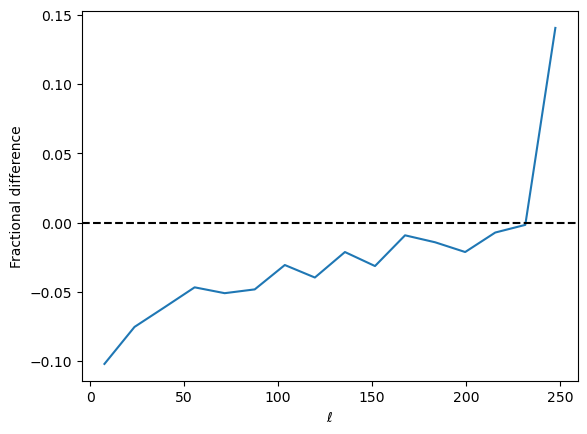

In [51]:
plt.plot(binned_ells, avg_Cb_decoupled/convolved_theory_cl - 1)
plt.axhline(0, ls='--', color='k')
plt.xlabel(r'$\ell$')
plt.ylabel(r'Fractional difference')